# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
pd.get_option("display.max_columns")
pd.set_option('display.max_columns', 300)
pd.get_option("display.max_rows")
pd.set_option('display.max_rows', 300)

import matplotlib.pyplot as plt
%matplotlib inline

import os
from os.path import join as opj
import gc

INPUT_PATH = '../../input/feedback-prize-english-language-learning/'

In [2]:
train_df = pd.read_csv(opj(INPUT_PATH, 'train.csv'))
test_df = pd.read_csv(opj(INPUT_PATH, 'test.csv'))
sub_df = pd.read_csv(opj(INPUT_PATH, 'sample_submission.csv'))

print('train_df.shape = ', train_df.shape)
print('test_df.shape = ', test_df.shape)
print('sub_df.shape = ', sub_df.shape)

train_df.shape =  (3911, 8)
test_df.shape =  (3, 2)
sub_df.shape =  (3, 7)


# EDA

In [3]:
all_texts = train_df['full_text'].values

In [4]:
len(all_texts)

3911

In [5]:
from transformers.models.deberta_v2 import DebertaV2TokenizerFast
model_name = 'microsoft/deberta-v3-base'
tokenizer = DebertaV2TokenizerFast.from_pretrained(model_name, trim_offsets=False)
special_tokens_dict = {'additional_special_tokens': ['\n\n']}
_ = tokenizer.add_special_tokens(special_tokens_dict)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# number of tokens
token_num_list = []
for idx in range(len(all_texts)):
    text = all_texts[idx]
    token_num = len(tokenizer(text)['input_ids'])
    token_num_list.append(token_num)

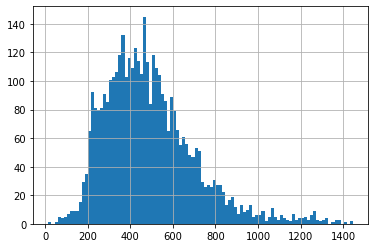

In [7]:
plt.hist(token_num_list, bins=100)
plt.grid();

In [8]:
# unique number of tokens
unique_token_num_list = []
for idx in range(len(all_texts)):
    text = all_texts[idx]
    unique_token_num = len(np.unique(tokenizer(text)['input_ids']))
    unique_token_num_list.append(unique_token_num)

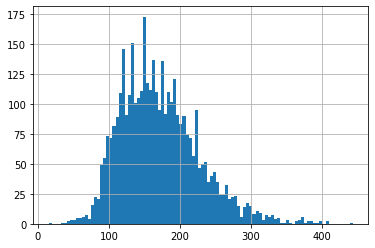

In [9]:
plt.hist(unique_token_num_list, bins=100)
plt.grid();

In [10]:
pd.DataFrame({"token_num":token_num_list, "unique_token_num":unique_token_num_list}).corr()

,token_num,unique_token_num
token_num,1.0000,0.8688
unique_token_num,0.8688,1.0000


In [11]:
from enchant.checker import SpellChecker
import enchant

def get_error_count(text):
    chkr = SpellChecker("en_US")
    chkr.set_text(text)
    count = 0
    for err in chkr:
        count += 1
    return count

def get_word_count(text):
    return len([word for word,pos in enchant.tokenize.en.tokenize(text)])

def get_unique_word_count(text):
    return len(np.unique([word for word,pos in enchant.tokenize.en.tokenize(text)]))

# train_df["error_count"] = train_df["full_text"].apply(lambda x: get_error_count(x))
# train_df["word_count"] = train_df["full_text"].apply(lambda x: get_word_count(x))
# train_df["error_ratio"] = train_df["error_count"] / train_df["word_count"]
# train_df["unique_word_count"] = train_df["full_text"].apply(lambda x: get_unique_word_count(x))
# train_df["unique_ratio"] = train_df["unique_word_count"] / train_df["word_count"]

In [15]:
%%time
np.vectorize(get_error_count)(train_df["full_text"])

CPU times: user 1min 15s, sys: 2.79 s, total: 1min 18s
Wall time: 1min 18s


array([ 4,  3,  0, ..., 12,  2,  1])

In [16]:
%%time 
train_df["full_text"].apply(lambda x: get_error_count(x))

CPU times: user 1min 16s, sys: 2.69 s, total: 1min 19s
Wall time: 1min 19s


0        4
1        3
2        0
3        0
4       10
        ..
3906    14
3907    14
3908    12
3909     2
3910     1
Name: full_text, Length: 3911, dtype: int64

In [21]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed

train_df["error_count"] = Parallel(n_jobs=-1)(delayed(get_error_count)(x) for x in tqdm(train_df["full_text"].values))
train_df["word_count"] = Parallel(n_jobs=-1)(delayed(get_word_count)(x) for x in tqdm(train_df["full_text"].values))
train_df["error_ratio"] = train_df["error_count"] / train_df["word_count"]
train_df["unique_word_count"] = Parallel(n_jobs=-1)(delayed(get_unique_word_count)(x) for x in tqdm(train_df["full_text"].values))
train_df["unique_ratio"] = train_df["unique_word_count"] / train_df["word_count"]

100%|██████████| 3911/3911 [00:00<00:00, 4551.41it/s]


CPU times: user 2.28 s, sys: 196 ms, total: 2.48 s
Wall time: 21.1 s


In [ ]:
# train_df["error_count"] = train_df["full_text"].apply(lambda x: get_error_count(x))
# train_df["word_count"] = train_df["full_text"].apply(lambda x: get_word_count(x))
# train_df["error_ratio"] = train_df["error_count"] / train_df["word_count"]
# train_df["unique_word_count"] = train_df["full_text"].apply(lambda x: get_unique_word_count(x))
# train_df["unique_ratio"] = train_df["unique_word_count"] / train_df["word_count"]

In [22]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,error_count,word_count,error_ratio,unique_word_count,unique_ratio
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,4,262,0.015267,134,0.511450
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,3,533,0.005629,141,0.264540
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,0,320,0.000000,122,0.381250
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,0,727,0.000000,221,0.303989
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,10,234,0.042735,105,0.448718


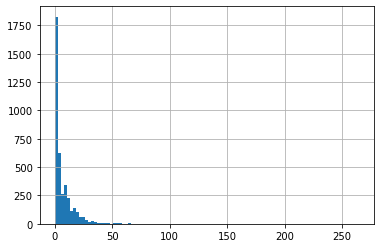

In [23]:
plt.hist(train_df["error_count"], bins=100)
plt.grid();

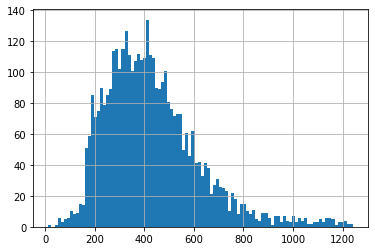

In [24]:
plt.hist(train_df["word_count"], bins=100)
plt.grid();

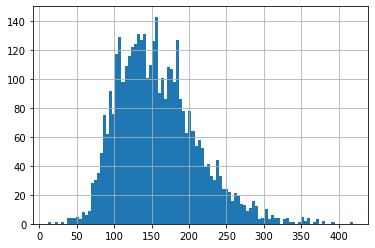

In [25]:
plt.hist(train_df["unique_word_count"], bins=100)
plt.grid();

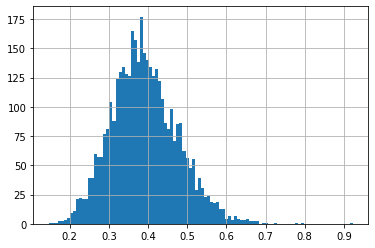

In [26]:
plt.hist(train_df["unique_ratio"], bins=100)
plt.grid();

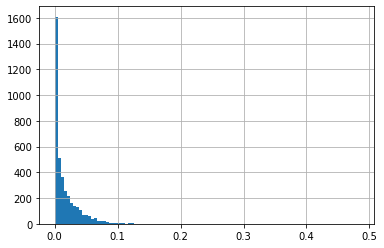

In [27]:
plt.hist(train_df["error_ratio"], bins=100)
plt.grid();

In [28]:
train_df["error_count"] = train_df["error_count"] / train_df["error_count"].max()
train_df["word_count"] = train_df["word_count"] / train_df["word_count"].max()
train_df["error_ratio"] = train_df["error_ratio"] / train_df["error_ratio"].max()
train_df["unique_word_count"] = train_df["unique_word_count"] / train_df["unique_word_count"].max()
train_df["unique_ratio"] = train_df["unique_ratio"] / train_df["unique_ratio"].max()

import os
os.makedirs("./result", exist_ok=True)
train_df.to_csv("./result/train.csv", index=False)

train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,error_count,word_count,error_ratio,unique_word_count,unique_ratio
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,0.015094,0.211120,0.031577,0.319809,0.554071
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.011321,0.429492,0.011641,0.336516,0.286585
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,0.000000,0.257857,0.000000,0.291169,0.413021
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,0.000000,0.585818,0.000000,0.527446,0.329321
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0.037736,0.188558,0.088389,0.250597,0.486111
